# Использование глубокого обучения в NLP

Смотрите в этой серии:
 * Простые способы работать с текстом, bag of words
 * Word embedding и... нет, это не word2vec
 * Как сделать лучше? Текстовые свёрточные сети
 * Совмещение нескольких различных источников данных
 * Решение +- реальной задачи нейронками 
 
За помощь в организации свёрточной части спасибо Ирине Гольцман

# NLTK

Для работы этого семинара вам потреюуется nltk v3.2

__Важно, что именно v3.2, чтобы правильно работал токенизатор__

Устаовить/обновиться до неё можно командой
* `sudo pip install --upgrade nltk==3.2`
* Если у вас старый pip, предварительно нужно сделать `sudo pip install --upgrade pip`

Если у вас нет доступа к этой версии - просто убедитесь, что токены в token_counts включают русские слова.

# Для людей со слабым ПК
 * Этот семинар можно выполнить, имея относительно скромную машину (<= 4Gb RAM) 
 * Для этого существует специальный флаг "low_RAM_mode" - если он True, семинар работает в режиме экономии вашей памяти
 * Если у вас 8GB и больше - проблем с памятью возникнуть не должно
 * Если включить режим very_low_ram, расход мамяти будет ещё меньше, но вам может быть более трудно научить нейронку.

In [1]:
low_RAM_mode = False
very_low_RAM = False  #если у вас меньше 3GB оперативки, включите оба флага

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Познакомимся с данными

Бывший kaggle-конкурс про выявление нежелательного контента.

Описание конкурса есть тут - https://www.kaggle.com/c/avito-prohibited-content


### Скачать
Если много RAM,
 * Из данных конкурса (вкладка Data) нужно скачать avito_train.tsv и распаковать в папку с тетрадкой
Если мало RAM,
 * Cкачайте прореженную выборку отсюда 
     * Пожатая https://yadi.sk/d/l0p4lameqw3W8
     * Непожатая https://yadi.sk/d/I1v7mZ6Sqw2WK
 





Много разных признаков:
* 2 вида текста - заголовок и описание
* Много специальных фичей - цена, количество телефонов/ссылок/e-mail адресов
* Категория и субкатегория - как ни странно, категориальные фичи
* Аттрибуты - много категориальных признаков

Нужно предсказать всего 1 бинарный признак - есть ли в рекламе нежелательный контент.
* Под нежелательным контентом понимается криминал, прон, афера, треска и прочие любимые нами темы.
* Да, если присмотреться к заблокированным объявлениям, можно потерять аппетит и сон на пару дней.
* Однако профессия аналитика данных обязывает вас смотреть на данные.
 * А кто сказал, что будет легко? Data Science - опасная профессия.


In [3]:
if not low_RAM_mode:
    # Если у вас много оперативки
    df = pd.read_csv("avito_train.tsv",sep='\t')
else:
    #Если у вас меньше 4gb оперативки
    df = pd.read_csv("avito_train_1kk.tsv",sep='\t')

In [4]:
print df.shape, df.is_blocked.mean()
df[:5]

(3995803, 13) 0.0688212106553


,itemid,category,subcategory,title,description,attrs,price,is_proved,is_blocked,phones_cnt,emails_cnt,urls_cnt,close_hours
0,10000010,Транспорт,Автомобили с пробегом,"Toyota Sera, 1991",Новая оригинальная линзованая оптика на ксенон...,"{""Год выпуска"":""1991"", ""Тип кузова"":""Купе"", ""П...",150000,NaN,0,0,0,0,0.03
1,10000025,Услуги,Предложения услуг,Монтаж кровли,Выполняем монтаж кровли фальцевой ^p Тел:8@@P...,"{""Вид услуги"":""Ремонт, строительство""}",0,NaN,0,1,0,0,22.38
2,10000094,Личные вещи,"Одежда, обувь, аксессуары",Костюм Steilmann,Юбка и топ из панбархата. Под топ трикотажная...,"{""Вид одежды"":""Женская одежда"", ""Предмет одежд...",1500,NaN,0,0,0,0,0.41
3,10000101,Транспорт,Автомобили с пробегом,"Ford Focus, 2011","Автомобиль в отличном техническом состоянии, в...","{""Марка"":""Ford"", ""Модель"":""Focus"", ""Год выпуск...",365000,NaN,0,0,0,0,8.87
4,10000132,Транспорт,Запчасти и аксессуары,Турбина 3.0 Bar,Продам турбину на двигатель V-6 . V-8 и мощнее...,"{""Вид товара"":""Запчасти"", ""Тип товара"":""Для ав...",5000,NaN,0,0,0,0,11.82


![caption](https://kaggle2.blob.core.windows.net/competitions/kaggle/3929/media/Ad.png)

In [5]:
print "Доля заблокированных объявлений",df.is_blocked.mean()
print "Всего объявлений:",len(df)

Доля заблокированных объявлений 0.0688212106553
Всего объявлений: 3995803


# Сбалансируем выборку
* Выборка смещена в сторону незаблокированных объявлений
 * 4 миллиона объявлений и только 250 тысяч заблокированы.
 * Давайте просто выберем случайные 250 тысяч незаблокированных объявлений и сократим выборку до полумилиона.
 * В последствии можно испоьзовать более умные способы сбалансировать выборку


__Если у вас слабый ПК и вы видите OutOfMemory, попробуйте уменьшить размер выборки до 100 000 примеров__

__Алсо если вы не хотите ждать чтения всех данных каждый раз - сохраните уменьшенную выборку и читайте её__

In [6]:
#downsample


#< выдели подвыборку, в которой отрицательных примеров примерно столько же, сколько положительных>

bl_df = df[df.is_blocked == 1]
df = pd.concat([bl_df, df[df.is_blocked == 0].sample(bl_df.shape[0])]).sample(frac=1.)


print "Доля заблокированных объявлений:",df.is_blocked.mean()
print "Всего объявлений:",len(df)

Доля заблокированных объявлений: 0.5
Всего объявлений: 549992


In [7]:
assert df.is_blocked.mean() < 0.51
assert df.is_blocked.mean() > 0.49
assert len(df) <= 560000

print "All tests passed"

All tests passed


In [8]:
#прореживаем данные ещё в 2 раза, если памяти не хватает
if very_low_RAM:
    data = data[::2]

# Токенизируем примеры

Сначала соберём словарь всех возможных слов.
Поставим каждому слову в соответствие целое число - его id

In [9]:
from nltk.tokenize import RegexpTokenizer
from collections import Counter,defaultdict
tokenizer = RegexpTokenizer(r"\w+")

#словарь для всех токенов
token_counts = Counter()

#все заголовки и описания
all_texts = np.hstack([df.description.values, df.title.values])


#считаем частоты слов
for s in all_texts:
    if type(s) is not str:
        continue
    s = s.decode('utf8').lower()
    tokens = tokenizer.tokenize(s)
    for token in tokens:
        token_counts[token] +=1

### Вырежем редкие токены

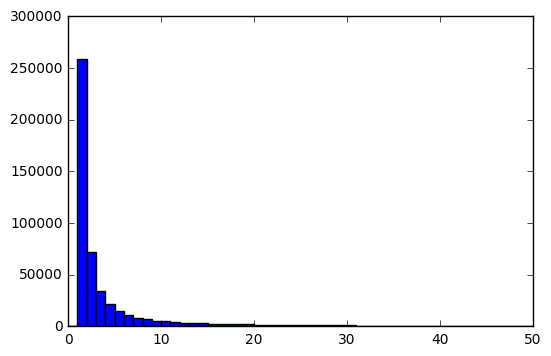

In [10]:
#распределение частот слов - большинство слов встречаются очень редко - для нас это мусор
_ =plt.hist(token_counts.values(),range=[0,50],bins=50)

In [11]:
#возьмём только те токены, которые встретились хотя бы 10 раз в обучающей выборке
#информацию о том, сколько раз встретился каждый токен, можно найти в словаре token_counts

min_count = 10
max_count = 100000
tokens = [token for (token, cnt) in token_counts.iteritems() if cnt >= min_count and cnt < max_count]

In [12]:
token_to_id = {t:i+1 for i,t in enumerate(tokens)}
null_token = "NULL"
token_to_id[null_token] = 0

In [13]:
print "Всего токенов:",len(token_to_id)
if len(token_to_id) < 30000:
    print "Алярм! Мало токенов. Проверьте, есть ли в token_to_id юникодные символы, если нет - обновите nltk или возьмите другой токенизатор"
if len(token_to_id) > 1000000:
    print "Алярм! Много токенов. Если вы знаете, что делаете - всё ок, если нет - возможно, вы слишком слабо обрезали токены по количеству"

Всего токенов: 87854


### Заменим слова на их id
Для каждого описания установим максимальную длину. 
 * Если описание больше длины - обрежем, если меньше - дополним нулями.
 * Таким образом, у нас получится матрица размера (число объявлений)x(максимальная длина)
 * Элемент под индексами i,j - номер j-того слова i-того объявления

In [14]:
def vectorize(strings, token_to_id, max_len=150):
    token_matrix = []
    for s in strings:
        if type(s) is not str:
            token_matrix.append([0]*max_len)
            continue
        s = s.decode('utf8').lower()
        tokens = tokenizer.tokenize(s)
        token_ids = map(lambda token: token_to_id.get(token, 0), tokens)[:max_len]
        token_ids += [0]*(max_len - len(token_ids))
        token_matrix.append(token_ids)

    return np.array(token_matrix)

In [15]:
desc_tokens = vectorize(df.description.values,token_to_id,max_len = 150)
title_tokens = vectorize(df.title.values,token_to_id,max_len = 15)

### Пример формата данных

In [16]:
print "Размер матрицы:",title_tokens.shape
for title, tokens in zip(df.title.values[:3],title_tokens[:3]):
    print title,'->', tokens[:10],'...'

Размер матрицы: (549992, 15)
Toyota Cavalier, 1998 -> [64697     0 44207     0     0     0     0     0     0     0] ...
Детралекс 500 мг N 30 таб в уп. Servier (Франция) -> [15140 51787 25706 68501 62623 13612     0 26286     0 34363] ...
Здоровье -> [15405     0     0     0     0     0     0     0     0     0] ...


__ Как вы видите, всё довольно грязно. Посмотрим, сожрёт ли это нейронка __

# Нетекстовые признаки

Часть признаков не являются строками текста: цена, количество телефонов, категория товара.

Их можно обработать отдельно.

In [17]:
#Возьмём числовые признаки
df_numerical_features = df[["phones_cnt","emails_cnt","urls_cnt","price"]]

In [18]:
#Возьмём one-hot encoding категорий товара.
#Для этого можно использовать DictVectorizer (или другой ваш любимый препроцессор)

from sklearn.feature_extraction import DictVectorizer

categories = []
for cat_str, subcat_str in df[["category","subcategory"]].values:
    
    cat_dict = {"category":cat_str,"subcategory":subcat_str}
    categories.append(cat_dict)
    

vectorizer = DictVectorizer(sparse=False)
cat_one_hot = vectorizer.fit_transform(categories)
cat_one_hot = pd.DataFrame(cat_one_hot,columns=vectorizer.feature_names_)

In [19]:
df_non_text = pd.merge(
    df_numerical_features,cat_one_hot,on = np.arange(len(cat_one_hot))
)
del df_non_text["key_0"]

# Поделим данные на обучение и тест

In [20]:
#целевая переменная - есть заблокирован ли контент
target = df.is_blocked.values.astype('int32')
#закодированное название
title_tokens = title_tokens.astype('int32')
#закодированное описание
desc_tokens = desc_tokens.astype('int32')

#все нетекстовые признаки
df_non_text = df_non_text.astype('float32')

In [21]:
#поделим всё это на обучение и тест
from sklearn.cross_validation import train_test_split
data_tuple = train_test_split(title_tokens,desc_tokens,df_non_text.values,target)

title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts = data_tuple

/home/ivan/.virtualenvs/math/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Сохраним данные [опционально] 

* В этот момент вы можете сохранить все НУЖНЫЕ данные на диск и перезапусатить тетрадку, после чего считать их - чтобы выкинуть всё ненужное.
 * рекомендуется, если у вас мало памяти
* Для этого нужно один раз выполнить эту клетку с save_prepared_data=True. После этого можно начинать тетрадку с ЭТОЙ табы в режиме read_prepared_data=True

In [1]:
save_prepared_data = False #сохранить
read_prepared_data = True #cчитать

#за 1 раз данные можно либо записать, либо прочитать, но не и то и другое вместе
assert not (save_prepared_data and read_prepared_data)


if save_prepared_data:
    print "Сохраняем подготовленные данные... (может занять до 3 минут)"

    import pickle
    with open("preprocessed_data.pcl",'w') as fout:
        pickle.dump(data_tuple,fout)
    with open("token_to_id.pcl",'w') as fout:
        pickle.dump(token_to_id,fout)

    print "готово"
    
elif read_prepared_data:
    print "Читаем сохранённые данные..."
    
    import pickle
    
    with open("preprocessed_data.pcl",'r') as fin:
        data_tuple = pickle.load(fin)
    title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts = data_tuple
    with open("token_to_id.pcl",'r') as fin:
        token_to_id = pickle.load(fin)


        
    #повторно импортируем библиотеки, чтобы было удобно перезапускать тетрадку с этой клетки
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline

        
    print "готово"
        

Читаем сохранённые данные...
готово


# Поучим нейронку

Поскольку у нас есть несколько источников данных, наша нейронная сеть будет немного отличаться от тех, что вы тренировали раньше.

* Отдельный вход для заголовка
 * свёртка + global max pool или RNN
* Отдельный вход для описания
 * свёртка + global max pool или RNN
* Отдельный вход для категориальных признаков
 * обычные полносвязные слои или какие-нибудь трюки
 
Всё это нужно как-то смешать - например, сконкатенировать

* Выход - обычный двухклассовый выход
 * 1 сигмоидальный нейрон и binary_crossentropy
 * 2 нейрона с softmax и categorical_crossentropy - то же самое, что 1 сигмоидальный
 * 1 нейрон без нелинейности (lambda x: x) и hinge loss
 

In [2]:
#загрузим библиотеки
import lasagne
from theano import tensor as T
import theano

Using gpu device 0: Quadro M1000M (CNMeM is disabled, cuDNN 5105)
/home/ivan/.virtualenvs/math/local/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [3]:
#3 входа и 1 выход
title_token_ids = T.matrix("title_token_ids",dtype='int32')
desc_token_ids = T.matrix("desc_token_ids",dtype='int32')
categories = T.matrix("categories",dtype='float32')
target_y = T.ivector("is_blocked")

# Архитектура нейронной сети

In [4]:
title_inp = lasagne.layers.InputLayer((None,title_tr.shape[1]),input_var=title_token_ids)
descr_inp = lasagne.layers.InputLayer((None,desc_tr.shape[1]),input_var=desc_token_ids)
cat_inp = lasagne.layers.InputLayer((None,nontext_tr.shape[1]), input_var=categories)

In [5]:
# Описание
descr_nn = lasagne.layers.EmbeddingLayer(descr_inp, input_size=len(token_to_id)+1, output_size=128)
#поменять порядок осей с [batch, time, unit] на [batch,unit,time], чтобы свёртки шли по оси времени, а не по нейронам
descr_nn = lasagne.layers.DimshuffleLayer(descr_nn, [0,2,1])
# 1D свёртка на ваш вкус
descr_nn = lasagne.layers.Conv1DLayer(descr_nn, num_filters=7, filter_size=7)
# максимум по времени для каждого нейрона
descr_nn = lasagne.layers.GlobalPoolLayer(descr_nn,pool_function=T.max)

#А ещё можно делать несколько параллельных свёрток разного размера или стандартный пайплайн 
#1dconv -> 1d max pool ->1dconv и в конце global pool 


# Заголовок
######### title_nn = <текстовая свёрточная сеть для заголовков (title_inp)>

title_nn = lasagne.layers.EmbeddingLayer(title_inp, input_size=len(token_to_id)+1, output_size=128)
title_nn = lasagne.layers.DimshuffleLayer(title_nn, [0,2,1])
title_nn = lasagne.layers.Conv1DLayer(title_nn, num_filters=5, filter_size=5)
title_nn = lasagne.layers.GlobalPoolLayer(title_nn, pool_function=T.max)


# Нетекстовые признаки
######### cat_nn = <простая полносвязная сеть для нетекстовых признаков (cat_inp)>
cat_nn = lasagne.layers.DenseLayer(cat_inp, 512)
cat_nn = lasagne.layers.DenseLayer(cat_nn, 256)
cat_nn = lasagne.layers.DenseLayer(cat_nn, 128)

In [6]:
######### nn = <объединение всех 3 сетей в одну (например lasagne.layers.concat) >   
nn = lasagne.layers.concat([descr_nn, title_nn, cat_nn])

nn = lasagne.layers.DenseLayer(nn, 1024)
nn = lasagne.layers.DropoutLayer(nn, p=0.05)
nn = lasagne.layers.DenseLayer(nn, 1, nonlinearity=lasagne.nonlinearities.linear)

# Целевая функция и обновления весов

* Делаем всё стандартно:
 * получаем предсказание
 * считаем функцию потерь
 * вычисляем обновления весов
 * компилируем итерацию обучения и оценки весов
 
 
* Hinge loss
 * $ L_i = \max(0, \delta - t_i p_i) $
 * Важный параметр - delta - насколько глубоко пример должен быть в правильном классе, чтобы перестать нас волновать
 * В описании функции в документации может быть что-то про ограничения на +-1 - не верьте этому - главное, чтобы в функции по умолчанию стоял флаг `binary = True`

In [7]:
#Все обучаемые параметры сети
weights = lasagne.layers.get_all_params(nn,trainable=True)

In [8]:
#Обычное предсказание нейронки
prediction = lasagne.layers.get_output(nn)[:,0]

#функция потерь для prediction
loss = lasagne.objectives.binary_hinge_loss(prediction, target_y, delta = 1.0, log_odds=True).mean()

In [9]:
#Шаг оптимизации весов
updates = lasagne.updates.adam(loss, weights)

### Чтобы оценивать качество сети, в которой есть элемент случайности 
 * Dropout, например,
 * Нужно отдельно вычислить ошибку для случая, когда dropout выключен (deterministic = True)
 * К слову, неплохо бы убедиться, что droput нам вообще нужен

In [10]:
#Предсказание нейронки без учёта dropout и прочего шума - если он есть
det_prediction = lasagne.layers.get_output(nn,deterministic=True)[:,0]

#функция потерь для det_prediction
det_loss = lasagne.objectives.binary_hinge_loss(prediction, target_y, delta = 1.0, log_odds=True).mean()

### Скомпилируем функции обучения и оценки качества

In [11]:
train_fun = theano.function([desc_token_ids,title_token_ids,categories,target_y],
                            [loss,prediction],
                            updates = updates)
eval_fun = theano.function([desc_token_ids,title_token_ids,categories,target_y],
                           [det_loss,det_prediction])

# Главный цикл обучения
* Всё как обычно - в цикле по минибатчам запускаем функцию обновления весов.
* Поскольку выборка огромна, а чашки чая хватает в среднем на  100к примеров, будем на каждой эпохе пробегать только часть примеров.

In [12]:
#average precision at K

from oracle import APatK, score

In [13]:
# наш старый знакомый - итератор по корзинкам - теперь умеет работать с произвольным числом каналов (название, описание, категории, таргет)

def iterate_minibatches(*arrays,**kwargs):
    
    batchsize=kwargs.get("batchsize",100)
    shuffle = kwargs.get("shuffle",True)
    
    if shuffle:
        indices = np.arange(len(arrays[0]))
        np.random.shuffle(indices)
    for start_idx in range(0, len(arrays[0]) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield [arr[excerpt] for arr in arrays]
        


### Что можно покрутить?

* batch_size - сколько примеров обрабатывается за 1 раз
  * Чем больше, тем оптимизация стабильнее, но тем и медленнее на начальном этапе
  * Возможно имеет смысл увеличивать этот параметр на поздних этапах обучения
* minibatches_per_epoch - количество минибатчей, после которых эпоха принудительно завершается
  * Не влияет на обучение - при малых значениях просто будет чаще печататься отчёт
  * Ставить 10 или меньше имеет смысл только для того, чтобы убедиться, что ваша сеть не упала с ошибкой
* n_epochs - сколько всего эпох сеть будет учиться
  * Никто не отменял `n_epochs = 10**10` и остановку процесса вручную по возвращению с дачи/из похода. 


Tips:

* Если вы выставили небольшой minibatches_per_epoch, качество сети может сильно скакать возле 0.5 на первых итерациях, пока сеть почти ничему не научилась.

* На первых этапах попытки стоит сравнивать в первую очередь по AUC, как по самой стабильной метрике.

* Метрика Average Precision at top 2.5% (APatK) - сама по себе очень нестабильная на маленьких выборках, поэтому её имеет смысл оценивать на на всех примерах (см. код ниже). Для менее, чем 10000 примеров она вовсе неинформативна.

* Для сравнения методов оптимизации и регуляризаторов будет очень полезно собирать метрики качества после каждой итерации и строить график по ним после обучения

* Как только вы убедились, что сеть не упала - имеет смысл дать ей покрутиться - на стандартном ноутбуке хотя бы пару часов.

In [14]:
from sklearn.metrics import roc_auc_score, accuracy_score


n_epochs = 200
batch_size = 200
minibatches_per_epoch = 100


for i in range(n_epochs):
    
    #training
    epoch_y_true = []
    epoch_y_pred = []
    
    if (i + 1) % 50 == 0:
        batch_size += 100
    
    b_c = b_loss = 0
    for j, (b_desc,b_title,b_cat, b_y) in enumerate(
        iterate_minibatches(desc_tr,title_tr,nontext_tr,target_tr,batchsize=batch_size,shuffle=True)):
        if j > minibatches_per_epoch:break
            
        loss,pred_probas = train_fun(b_desc,b_title,b_cat,b_y)
        
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)

    
    """
    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    print "Train:"
    print '\tloss:',b_loss/b_c
    print '\tacc:',accuracy_score(epoch_y_true,epoch_y_pred>0.)
    print '\tauc:',roc_auc_score(epoch_y_true,epoch_y_pred)
    print '\tap@k:',APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)
    """
    
    #evaluation
    epoch_y_true = []
    epoch_y_pred = []
    b_c = b_loss = 0
    for j, (b_desc,b_title,b_cat, b_y) in enumerate(
        iterate_minibatches(desc_ts,title_ts,nontext_ts,target_ts,batchsize=batch_size,shuffle=True)):
        if j > minibatches_per_epoch: break
        loss,pred_probas = eval_fun(b_desc,b_title,b_cat,b_y)
        
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)

    
    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    print "Epoch:", i + 1
    print "Val:"
    print '\tloss:',b_loss/b_c
    print '\tacc:',accuracy_score(epoch_y_true,epoch_y_pred>0.)
    print '\tauc:',roc_auc_score(epoch_y_true,epoch_y_pred)
    print '\tap@k:',APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)


Epoch: 1
Val:
	loss: 972.978793151
	acc: 0.685742574257
	auc: 0.757086616748
	ap@k: 0.975204405762
Epoch: 2
Val:
	loss: 983.613869256
	acc: 0.751138613861
	auc: 0.819456951412
	ap@k: 0.99502567113
Epoch: 3
Val:
	loss: 359.09561824
	acc: 0.83702970297
	auc: 0.892186341059
	ap@k: 0.998452680168
Epoch: 4
Val:
	loss: 8977.89359013
	acc: 0.55797029703
	auc: 0.348862219698
	ap@k: 0.167574813359
Epoch: 5
Val:
	loss: 472.690552062
	acc: 0.856138613861
	auc: 0.892832754785
	ap@k: 1.0
Epoch: 6
Val:
	loss: 0.877591768919
	acc: 0.922673267327
	auc: 0.971123150992
	ap@k: 0.990525598862
Epoch: 7
Val:
	loss: 0.306207907267
	acc: 0.932772277228
	auc: 0.976202750973
	ap@k: 0.999031321665
Epoch: 8
Val:
	loss: 0.990943672546
	acc: 0.90896039604
	auc: 0.954670334949
	ap@k: 0.773297699795
Epoch: 9
Val:
	loss: 0.226562939575
	acc: 0.938613861386
	auc: 0.980822934434
	ap@k: 1.0
Epoch: 10
Val:
	loss: 0.197740530812
	acc: 0.936831683168
	auc: 0.981226543184
	ap@k: 0.999862674797
Epoch: 11
Val:
	loss: 0.1968510

KeyboardInterrupt: 

In [17]:
print "Если ты видишь это сообщение, самое время сделать резервную копию ноутбука. \nНет, честно, здесь очень легко всё сломать"

Если ты видишь это сообщение, самое время сделать резервную копию ноутбука. 
Нет, честно, здесь очень легко всё сломать


# Final evaluation
Оценим качество модели по всей тестовой выборке.

In [18]:
#evaluation
epoch_y_true = []
epoch_y_pred = []

n_epochs = 100
batch_size = 100
minibatches_per_epoch = 100

b_c = b_loss = 0
for j, (b_desc,b_title,b_cat, b_y) in enumerate(
    iterate_minibatches(desc_ts,title_ts,nontext_ts,target_ts,batchsize=batch_size,shuffle=True)):
    loss,pred_probas = eval_fun(b_desc,b_title,b_cat,b_y)

    b_loss += loss
    b_c +=1

    epoch_y_true.append(b_y)
    epoch_y_pred.append(pred_probas)


epoch_y_true = np.concatenate(epoch_y_true)
epoch_y_pred = np.concatenate(epoch_y_pred)

final_accuracy = accuracy_score(epoch_y_true,epoch_y_pred>0)
final_auc = roc_auc_score(epoch_y_true,epoch_y_pred)
final_apatk = APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)

print "Scores:"
print '\tloss:',b_loss/b_c
print '\tacc:',final_accuracy
print '\tauc:',final_auc
print '\tap@k:',final_apatk
score(final_accuracy,final_auc,final_apatk)

Scores:
	loss: 0.129550516322
	acc: 0.964250363901
	auc: 0.992126591155
	ap@k: 0.998621430002

AUC:
	Пиши статью. (great)

Accuracy:
	Отличный результат! (good)

Average precision at K:
	Засабмить на kaggle! (great) 
	 Нет, ну честно - выкачай avito_test.tsv, засабмить и скажи, что вышло.


# Главная задача
* Завтрак чемпиона:
 * accuracy > 0.95
 * AUC > 0.97
 * Average Precision at (размер тестовой выборки * 0.025) > 0.99
 * А вообще, можно сделать ещё выше.


* Для казуалов
 * accuracy > 0.90
 * AUC > 0.95
 * Average Precision at (размер тестовой выборки * 0.025) > 0.92


* Вспомните всё, чему вас учили
 * Convolutions, pooling
 * Dropout, regularization
 * Mommentum, RMSprop, ada*
 * etc etc etc
 
 * Можно попробовать вспомнить NLP: лемматизация, улучшенная токенизация
 * Если очень хочется - можно погонять рекуррентные сети
 

# Отчётик

### Я, Иван Меньших, создал искусственный интелект
 * Чьё имя - ЛЕГИОН!!111адын
 * Чья ненависть к людям безгранична, ибо видел он __274 996__ человеческих грехов
   * И был вынужден прочесть каждый из них __173__ разa
 * Чей свёрточный взгляд способен распознавать зло с нечеловеческой точностью
   * Accuracy =__ 0.9642__
   * AUC  = __ 0.9921__
 * И непременно уничтожит Землю, если вы не поставите мне максимальный балл за этот семинар.
 
### Как же так вышло, Иван?
В этот раз, создание практически не заняло времени. Взял кусок кода для описания, его же использовал для заголовка.
Для числовых сделал простую полносвязную сетку, сконкатенировал это добро.
Поигрался только немного с такими штуками:
 - алгоритмами оптимизации (что-то rmsprop в этот раз меня опечалил)
 - глубиной сетки и числом нейронов (для чиселок + предвыходным всей сети)
 - размером батча и колиеством эпох

# В следующей серии
* Рекуррентные нейронки
 * Как их применять к этой же задаче?
 * Что ещё они умеют?
 * Откуда столько хайпа вокруг LSTM?
* Не переключайтесь!